In [1]:
# ! curl -L -o ./dataset/archive.zip https://www.kaggle.com/api/v1/datasets/download/fanconic/skin-cancer-malignant-vs-benign
# ! unzip -o ./dataset/archive.zip -d ./dataset
# ! rm ./dataset/archive.zip

In [2]:
%pip install torch torchvision matplotlib numpy pandas scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Lee las imágenes y cárgalas en Tensores de PyTorch para ser procesados.
# The images are in 4 folders:
# dataset/train/benign, dataset/train/malignant, dataset/test/benign, dataset/test/malignant
# where benign and malignant are the two classes of skin cancer.
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class SkinCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = []
        for i, d in enumerate(os.listdir(root_dir)):
            self.classes.append(d)
            for f in os.listdir(os.path.join(root_dir, d)):
                self.images.append(os.path.join(root_dir, d, f))
                self.labels.append(i)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = SkinCancerDataset('./dataset/train', transform=transform)
test_dataset = SkinCancerDataset('./dataset/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print('Train dataset size:', len(train_dataset))
print('Train data samples:', train_dataset[0][0].shape)
print('Test dataset size:', len(test_dataset))
print('Test data samples:', test_dataset[0][0].shape)


Train dataset size: 2637
Train data samples: torch.Size([3, 224, 224])
Test dataset size: 660
Test data samples: torch.Size([3, 224, 224])


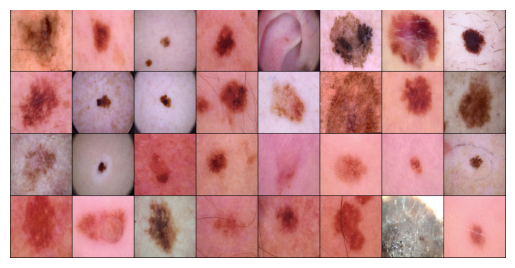

malignant benign malignant benign benign malignant malignant benign benign benign malignant benign benign malignant benign benign malignant benign benign benign benign benign benign malignant benign benign malignant benign benign benign malignant benign


In [4]:

import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % train_dataset.classes[labels[j]] for j in range(32)))


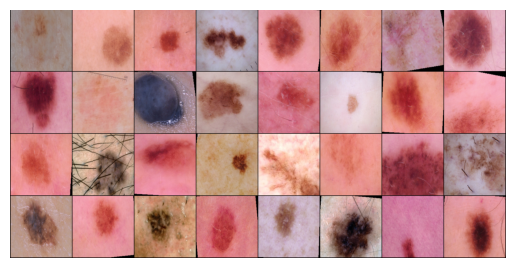

Train dataset augmented size: 7911
Train data augmented samples: torch.Size([3, 224, 224])


In [5]:
# Aplica técnicas de Data Augmentation (rotaciones, reflexiones especulares, etc.).
import random
import torchvision.transforms.functional as TF

class RandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees
        
    def __call__(self, x):
        angle = random.uniform(-self.degrees, self.degrees)
        return TF.rotate(x, angle)
    
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, x):
        if random.random() < self.p:
            return TF.hflip(x)
        return x
    
class RandomVerticalFlip:
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, x):
        if random.random() < self.p:
            return TF.vflip(x)
        return x

class RandomResizedCrop:
    def __init__(self, size, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333)):
        self.size = size
        self.scale = scale
        self.ratio = ratio
        
    def __call__(self, x):
        i, j, h, w = transforms.RandomResizedCrop.get_params(x, scale=self.scale, ratio=self.ratio)
        return TF.resized_crop(x, i, j, h, w, self.size)

# Define the augmentation transform
transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToPILImage(),
    RandomRotation(10),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomResizedCrop((224, 224)),
    transforms.ToTensor()
])

# Create a new dataset with augmented samples
class AugmentedSkinCancerDataset(Dataset):
    def __init__(self, original_dataset, transform=None, augment_factor=3):
        self.original_dataset = original_dataset
        self.transform = transform
        self.augment_factor = augment_factor
        
    def __len__(self):
        return len(self.original_dataset) * self.augment_factor
    
    def __getitem__(self, idx):
        original_idx = idx % len(self.original_dataset)
        image, label = self.original_dataset[original_idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create the augmented dataset and dataloader
train_dataset_augmented = AugmentedSkinCancerDataset(train_dataset, transform=transform_augmented)
train_loader_augmented = torch.utils.data.DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

dataiter = iter(train_loader_augmented)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

print('Train dataset augmented size:', len(train_dataset_augmented))
print('Train data augmented samples:', train_dataset_augmented[0][0].shape)


In [6]:
# Instancia  una  red  neuronal  profunda  de  las  disponibles  en  TorchVision  (VGG, 
# ResNet) y descarga los pesos por defecto (DEFAULT) entrenados en el conjunto 
# de datos ImageNet.
import torchvision.models as models

model = models.vgg16(pretrained=True)
print(model)

/home/vscode/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vscode/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
# Elimina  las  capas  Lineales  de  la  etapa  clasificadora  de  la  red  neuronal  y 
# sobrescríbelas  con  unas  nuevas  capas  lineales  con  los  mismos  parámetros  de 
# configuración que las eliminadas.
import torch.nn as nn

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 2)
)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
# Realiza un entrenamiento de esta red neuronal -con la nueva cabeza 
# clasificadora-, actualizando solo los pesos de las capas nuevas.
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 10 == 9:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0

train(model, train_loader_augmented, criterion, optimizer, device, epochs=2)



[1,    10] loss: 0.692
[1,    20] loss: 0.674
[1,    30] loss: 0.645
[1,    40] loss: 0.616
[1,    50] loss: 0.537
[1,    60] loss: 0.504
[1,    70] loss: 0.442
[1,    80] loss: 0.411
[1,    90] loss: 0.537
[1,   100] loss: 0.407
[1,   110] loss: 0.436
[1,   120] loss: 0.374
[1,   130] loss: 0.370
[1,   140] loss: 0.335
[1,   150] loss: 0.431
[1,   160] loss: 0.380
[1,   170] loss: 0.481
[1,   180] loss: 0.402
[1,   190] loss: 0.349
[1,   200] loss: 0.379
[1,   210] loss: 0.362
[1,   220] loss: 0.416
[1,   230] loss: 0.401
[1,   240] loss: 0.404
[2,    10] loss: 0.361
[2,    20] loss: 0.362
[2,    30] loss: 0.348
[2,    40] loss: 0.366
[2,    50] loss: 0.365
[2,    60] loss: 0.302
[2,    70] loss: 0.367
[2,    80] loss: 0.311
[2,    90] loss: 0.319
[2,   100] loss: 0.287
[2,   110] loss: 0.391
[2,   120] loss: 0.334
[2,   130] loss: 0.324
[2,   140] loss: 0.294
[2,   150] loss: 0.306
[2,   160] loss: 0.372
[2,   170] loss: 0.325
[2,   180] loss: 0.328
[2,   190] loss: 0.330
[2,   200] 

In [9]:
# Determina las métricas de función de pérdida (loss) y precisión para los conjuntos 
# de datos de entrenamiento y test
def evaluate(model, data_loader, device):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return loss / total, correct / total

train_loss, train_accuracy = evaluate(model, train_loader, device)
test_loss, test_accuracy = evaluate(model, test_loader, device)

print('Train loss:', train_loss)
print('Train accuracy:', train_accuracy)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Train loss: 0.008667459330709766
Train accuracy: 0.8794084186575654
Test loss: 0.009464487275390914
Test accuracy: 0.8696969696969697


In [10]:
# Evalúa el rendimiento de la red neuronal en el conjunto de test.
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

test(model, test_loader, device)


Accuracy of the network on the test images: 86 %
